In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re 
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
# from jupyter_dash import JupyterDash
# from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 



In [ ]:
def scatter_it_sampled(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False, sampled_question_ids_path=None):
    # Subsample data to plot, so the plot is not too busy.
    #dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    print(sampled_question_ids_path)

    with open(sampled_question_ids_path, 'rb') as f:
        sampled_ids = pickle.load(f)
    all_ids = dataframe['question_id'].tolist()
    remaining_ids = set(all_ids) - set(sampled_ids)
    
    df_one = dataframe.loc[dataframe['question_id'].isin(sampled_ids)]
    df_two = dataframe.loc[dataframe['question_id'].isin(remaining_ids)]
    concatenated = pd.concat([df_two.assign(dataset='remaining'), df_one.assign(dataset='sampled')])


    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=concatenated,
                           palette=['lightblue', 'darkblue'],
                           hue='dataset',
                           style='dataset',
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=False,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    plot.set_title(f"{model}-{title} Data Map", fontsize=17)

    fig.tight_layout()
    fig.show()
    #fig_save = fig.get_figure()
    #sample_name = os.path.basename(os.path.splitext(sampled_question_ids_path)[0])
    #fig_save.savefig(args.base_path+sample_name+'_datamap.pdf') 


if __name__ == "__main__":
    base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
    #/home/jaspreet/vl-pretraining/src/dataset_selection/sampling/samples/LXR111/multilabel_full/global_random/seed_965/budget_10.pkl
    # '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_10.pkl'
    sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/max_confidence/seed_965/budget_30.pkl'
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    #print(args.base_path)
    #sampled_question_ids_path = '../src/dataset_selection/sampling/samples/LXR111/myo-sports/beta/beta_kernel/linear/seed_388/alpha_2_beta_2_budget_30.pkl'
    scatter_it_sampled(df, title=' classwise max confidence Budget: 30,', show_hist=True, sampled_question_ids_path=sampling_ids)


/home/jaspreet/.conda/envs/lxmert/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


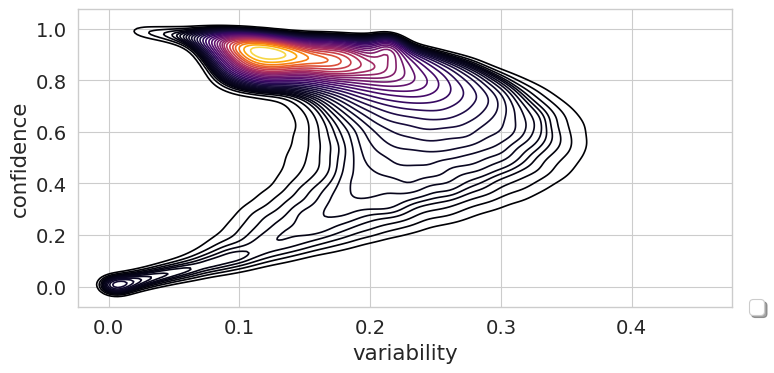

In [9]:
def scatter_it_kde(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    # dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    #dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    #dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    dataframe['correct.'] = dataframe['correctness']
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")
    pal.reverse()

    # plot = sns.scatterplot(x=main_metric,
    #                        y=other_metric,
    #                        ax=ax0,
    #                        data=dataframe,
    #                        hue=hue,
    #                        palette=pal,
    #                        style=style,
    #                        s=30)
    plot = sns.kdeplot(data=dataframe, x=main_metric, y=other_metric, 
                        cmap='inferno', shade=False, shade_lowest=False, n_levels=30) # shade_lowest=False, hue=hue
    # sns.kdeplot(
    #     data=x,
    #     data2=y,
    #     shade=False,
    #     shade_lowest=False,
    #     cmap='inferno',#viridis',
    #     n_levels=30)

    # # Annotate Regions.
    # bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    # an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
    #               va="center", ha="center", rotation=350, bbox=bb('black'))
    # an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
    #               va="center", ha="center", bbox=bb('r'))
    # an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
    #               va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=False,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')


    # fig = px.scatter(dataframe, x=main_metric,
    #                        y=other_metric, 
    #                        color=hue,
    #                        symbol=style,
    #                        size_max=30)
    # fig.show()

    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal', range=[0,1])
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        #plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        plot2 = dataframe.hist(column=['correct.'], ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2[0].set_title('')
        plot2[0].set_xlabel('correctness')
        plot2[0].set_ylabel('')

    fig.tight_layout()
    fig.show()
    # fig_save = fig.get_figure()
    # fig_save.savefig(args.base_path+'datamap.pdf') 

if __name__ == "__main__":
    base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
    #/home/jaspreet/vl-pretraining/src/dataset_selection/sampling/samples/LXR111/multilabel_full/global_random/seed_965/budget_10.pkl
    # '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_10.pkl'
    sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_2_budget_30.pkl'
    df = pd.read_pickle(base_path+"datamap_metrics.pkl")
    #print(args.base_path)
    #sampled_question_ids_path = '../src/dataset_selection/sampling/samples/LXR111/myo-sports/beta/beta_kernel/linear/seed_388/alpha_2_beta_2_budget_30.pkl'
    scatter_it_kde(df, hue_metric ='correct.', title='', model='LXMERT', show_hist=False)


In [32]:
sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/max_confidence/seed_965/budget_33.pkl'

with open(sampling_ids, 'rb') as f:
    sampled_ids = pickle.load(f)
len(sampled_ids)

188223

In [23]:
base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

with open(sampling_ids, 'rb') as f:
    sampled_ids = pickle.load(f)

df = df.loc[df['question_id'].isin(sampled_ids)]

questions = df['Question'].tolist()
questions = [i[0].lower() for i in questions]
df['Question'] = questions

targets = df['Target'].tolist()
targets = [i[0] for i in targets]
df['Target'] = targets
targets = df['Target'].tolist()

with open("../../../data/vqa/mscoco_question_types.txt") as f:
    question_types_list = f.read().splitlines() 
question_types_list = list(set(question_types_list))
question_types_list = sorted(question_types_list, key=len) 
question_types_list.reverse()

question_types_freq = {}
question_answer_pairs = {}
question_types_full = {}

for i in question_types_list:
    question_types_freq[i] = 0
    question_answer_pairs[i] = []
    question_types_full[i] = []



for idx, question in enumerate(questions):
    counter = 0
    target_list = [x.strip() for x in targets[idx].split(',')]
    matches = []
    for question_type in question_types_freq:
        
        if question.startswith(question_type):
            matches.append(question_type)
    if len(matches) != 0:
        quest_type_max = max(matches, key=len)
        question_types_freq[quest_type_max] +=1
        question_answer_pairs[quest_type_max].extend(target_list)
        question_types_full[quest_type_max].extend(question)
        counter+=1
    if counter == 0:
        question_types_freq['none of the above'] +=1
        question_answer_pairs['none of the above'].extend(target_list)
        question_types_full['none of the above'].extend(question)

    
res = sum(list(question_types_freq.values()))
assert res == len(questions)
question_types_freq = dict( sorted(question_types_freq.items(), key=operator.itemgetter(1),reverse=True))
question_types_list = list(question_types_freq.keys())[:10]
question_types_freq_list = list(question_types_freq.values())[:10]
data = {'Question Type': question_types_list, 'Frequency': question_types_freq_list}
question_freqs = pd.DataFrame.from_dict(data)

In [56]:
question_counts_full = df['Question'].value_counts()


([<matplotlib.patches.Wedge at 0x7ff39e9a5dc0>,
 [Text(0.9135512791500644, 0.6127185817023026, 'what'),
  Text(-0.17607661748897452, 1.0858162942107847, 'how many'),
  Text(-0.9954843671413085, 0.4679859771160548, 'what color is the'),
  Text(-1.036375562766285, -0.368681017820102, 'what is the'),
  Text(-0.6048398306626018, -0.9187865798127633, 'is the'),
  Text(-0.014776659592190988, -1.0999007456726706, 'what is'),
  Text(0.49163372583056547, -0.9840204670767557, 'what kind of'),
  Text(0.7989732769542515, -0.7560699059696697, 'is this a'),
  Text(0.9900320527461133, -0.479412697511567, 'what are the'),
  Text(1.0876874580935871, -0.1641218861270831, 'is this')])

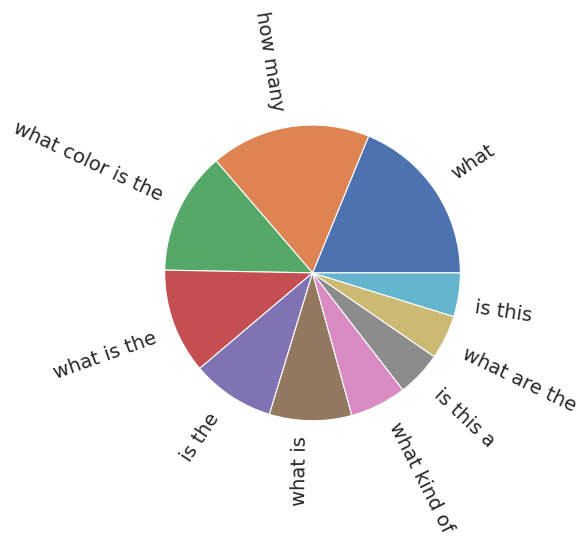

In [24]:
plt.pie(question_types_freq_list, labels=question_types_list, rotatelabels=True)

In [25]:
# base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
# sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_10.pkl'
# df = pd.read_pickle(base_path+"datamap_metrics.pkl")

# region = 'ambiguous'
# confidence_threshold = 0.01
# variability_threshold = 0.01

# if region == 'hard':
#     # segment instances thresholded on confidence and variability to separate regions on datamap 
#     df = df.loc[(df['confidence'] < confidence_threshold) & (df['variability'] < variability_threshold)]
# elif region == 'easy':
#     df = df.loc[(df['confidence'] > confidence_threshold) & (df['variability'] < variability_threshold)]
# else:
#     df = df.loc[(df['confidence'] > 0.4) &(df['confidence'] < 0.8) & (df['variability'] > 0.4)]
base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
sampling_ids = '../../../src/dataset_selection/sampling/samples/LXR111/multilabel_full/beta/beta_kernel/tophat/seed_965/alpha_2_beta_1_budget_30.pkl'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

with open(sampling_ids, 'rb') as f:
    sampled_ids = pickle.load(f)

df = df.loc[df['question_id'].isin(sampled_ids)]
print(df.shape)

questions = df['Question'].tolist()
questions = [i[0].lower() for i in questions]
df['Question'] = questions

targets = df['Target'].tolist()
targets = [i[0] for i in targets]
df['Target'] = targets
targets = df['Target'].tolist()

with open("../../../data/vqa/mscoco_question_types.txt") as f:
    question_types_list = f.read().splitlines() 
question_types_list = list(set(question_types_list))
question_types_list = sorted(question_types_list, key=len) 
question_types_list.reverse()

question_types_freq = {}
question_answer_pairs = {}
question_types_full = {}

for i in question_types_list:
    question_types_freq[i] = 0
    question_answer_pairs[i] = []
    question_types_full[i] = []



for idx, question in enumerate(questions):
    counter = 0
    target_list = [x.strip() for x in targets[idx].split(',')]
    matches = []
    for question_type in question_types_freq:
        
        if question.startswith(question_type):
            matches.append(question_type)
    if len(matches) != 0:
        quest_type_max = max(matches, key=len)
        question_types_freq[quest_type_max] +=1
        question_answer_pairs[quest_type_max].extend(target_list)
        question_types_full[quest_type_max].extend(question)
        counter+=1
    if counter == 0:
        question_types_freq['none of the above'] +=1
        question_answer_pairs['none of the above'].extend(target_list)
        question_types_full['none of the above'].extend(question)

    
res = sum(list(question_types_freq.values()))
assert res == len(questions)
question_types_freq = dict( sorted(question_types_freq.items(), key=operator.itemgetter(1),reverse=True))
question_types_list = list(question_types_freq.keys())[:10]
question_types_freq_list = list(question_types_freq.values())[:10]
data = {'Question Type': question_types_list, 'Frequency': question_types_freq_list}
question_freqs = pd.DataFrame.from_dict(data)

(185817, 9)


[Text(0, 0.5, '')]

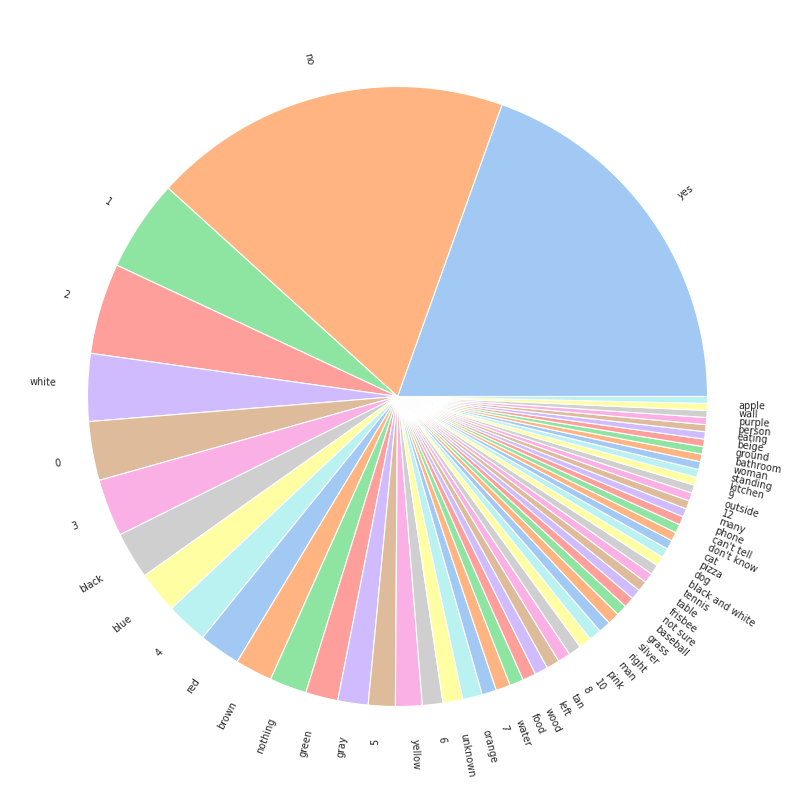

In [26]:
all_targets = []
for question, answer in question_answer_pairs.items():
    all_targets.extend(answer)

df_target = pd.DataFrame(all_targets, columns=['targets'])
question_counts = df_target['targets'].value_counts()
palette_color = sns.color_palette('pastel')
ax = question_counts[:60].plot(kind='pie', colors=palette_color, textprops={'fontsize': 7}, rotatelabels=True, figsize=(10, 20))
ax.set(ylabel=None)


[Text(0, 0.5, '')]

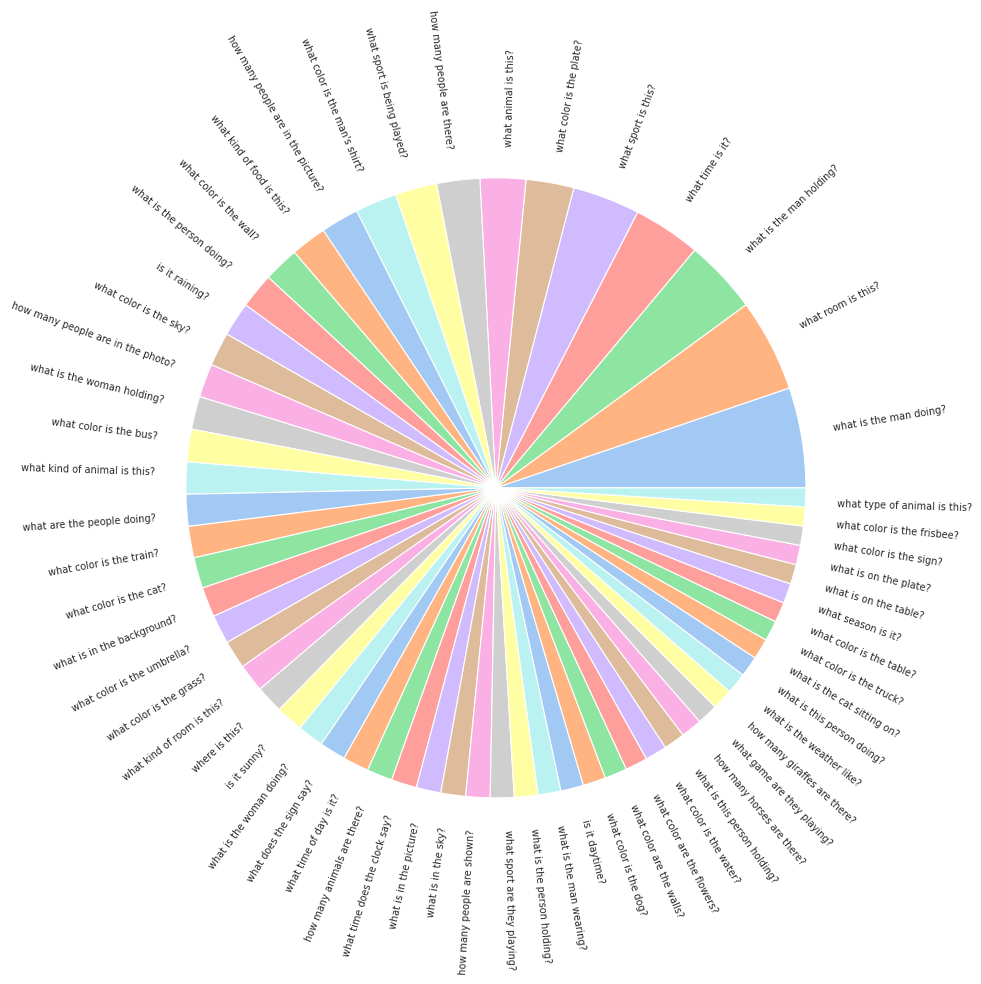

In [28]:
question_counts = df['Question'].value_counts()
palette_color = sns.color_palette('pastel')
ax = question_counts[:60].plot(kind='pie', colors=palette_color, textprops={'fontsize': 7}, rotatelabels=True, figsize=(10, 20))
ax.set(ylabel=None)

In [84]:
percentage = {}
for val, cnt in question_counts[:60].iteritems():
    percentage[val] = round(question_counts[val]/question_counts_full[val], 2)
question_percentage = sorted(percentage.items(), key=lambda x:x[1], reverse=True)


In [85]:
question_percentage

[('what kind of school might we assume he attends?', 1.0),
 ('what time is the phone displaying?', 1.0),
 ('whose favorite doughnuts are pictured?', 1.0),
 ('what are the police eating?', 1.0),
 ('what is the name of the cafe on the mug?', 1.0),
 ('what is laying across the teacup?', 1.0),
 ("what is thru the man's head?", 1.0),
 ('what are the letters on the left?', 1.0),
 ('whose robotics studio is this?', 1.0),
 ('what street is the trust company on?', 1.0),
 ('what brand name is under the clock?', 1.0),
 ('what color is the post-it?', 1.0),
 ('what is the donut box sitting on?', 1.0),
 ('what kind of wrapping paper do you see?', 1.0),
 ('how can you tell he is listening to music?', 1.0),
 ('what word is centered between the headlights?', 0.5),
 ('what is on green object on the white sign?', 0.5),
 ('what is the cat touching?', 0.5),
 ('what pattern is the batters jersey?', 0.5),
 ('what costume is the person wearing?', 0.5),
 ('who is sponsoring the timekeeping system for the tourn

In [63]:
percentage

{85: 0.003745318352059925,
 75: 0.003484320557491289,
 70: 0.0034129692832764505,
 35: 0.004750593824228029,
 19: 0.007849293563579277,
 18: 0.007704160246533128,
 16: 0.009009009009009009,
 13: 0.010279001468428781,
 12: 0.010218978102189781,
 10: 0.012228260869565218,
 9: 0.013245033112582781,
 8: 0.015665796344647518,
 7: 0.016229712858926344,
 6: 0.019002375296912115,
 5: 0.020713463751438434,
 4: 0.019507186858316223,
 3: 0.0341796875,
 2: 0.06055363321799308,
 1: 0.05384063173007897}

([<matplotlib.patches.Wedge at 0x7f394f2484f0>,
 [Text(0.8350765483050968, 0.7159938257211758, 'what'),
  Text(-0.5439059411408922, 0.9561204564235829, 'how many'),
  Text(-1.0997981816599005, -0.021070349251413337, 'what is'),
  Text(-0.7925737747341034, -0.7627757282476514, 'what is the'),
  Text(-0.1783187396633355, -1.0854503337716008, 'what time'),
  Text(0.3817170155982672, -1.0316453460384303, 'what does the'),
  Text(0.7627757282476516, -0.7925737747341032, 'what color is the'),
  Text(0.966363461152008, -0.5254918276722403, 'what is the man'),
  Text(1.0578384273132009, -0.3016253664722751, 'what is on the'),
  Text(1.0959155738131467, -0.09470509528954293, 'none of the above')])

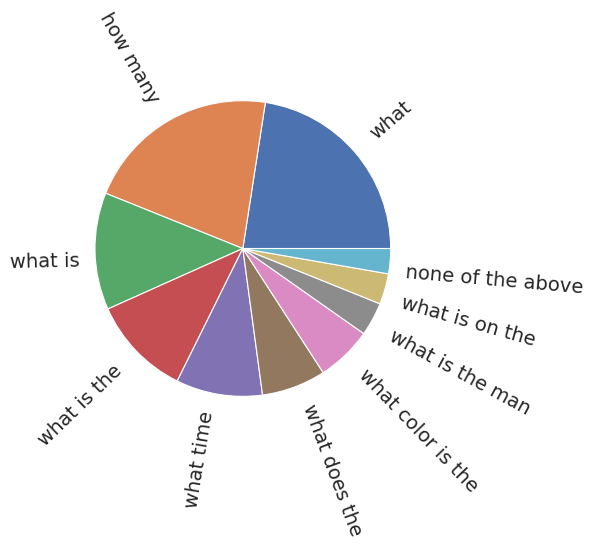

In [44]:
plt.pie(question_types_freq_list, labels=question_types_list, rotatelabels=True)